# Load the data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
df = pd.read_csv('./drive/MyDrive/Projects/exchange-rate/data/Foreign_Exchange_Rates.csv')
# Convert the entire DataFrame to numeric
selected_columns = df.loc[:, df.columns != 'Time Serie']
selected_columns = selected_columns.apply(pd.to_numeric, errors='coerce')
df.update(selected_columns)
df['Time Serie'] = pd.to_datetime(df['Time Serie'])
df['Time Serie']

# Pre-process the data

In [4]:
# Fill ND values with previous and next values
df = df.replace("ND", np.nan)
df = df.bfill().ffill()

In [4]:
num = df.isnull().sum()
len(df)

5217

In [5]:
print("Total number of days between {} and {} are {}".format(df['Time Serie'].min().date(), df['Time Serie'].max().date(), (df['Time Serie'].max() - df['Time Serie'].min()).days+1))

Total number of days between 2000-01-03 and 2019-12-31 are 7303


In [6]:
# Prepare a full dataframe
num_records = (df['Time Serie'].max() - df['Time Serie'].min()).days+1
data = {}
data["Time Serie"] = pd.date_range(df['Time Serie'].min().date(), df['Time Serie'].max().date(), freq="D")

df_full = pd.DataFrame(data=data)
# df_full = df_full.set_index("DATE")
df_full = df_full.merge(df, left_index=True, right_index=True, how="left")
df_full = df_full.bfill().ffill()

In [ ]:
df_full.head

In [ ]:
# compute all the exchange rates wrt. Norway
cols = [col.replace("US$", "Norway-NOK") for col in df.columns]
nor_df = pd.DataFrame(data = df, columns=cols)
nor_df.iloc[:, 2:] = df.iloc[:, 2:].div(df['NORWAY - NORWEGIAN KRONE/US$'], axis=0)
nor_df.iloc[:, 2:] = nor_df.iloc[:, 2:].applymap(lambda x: 1/x)
nor_df['US$/Norway_NOK'] = df['NORWAY - NORWEGIAN KRONE/US$']

nor_df.head


In [6]:
nor_df = nor_df.drop(columns = ['NORWAY - NORWEGIAN KRONE/Norway-NOK'])


In [7]:
nor_df.to_csv('./drive/MyDrive/Projects/exchange-rate/data/norway-exchangerate')

In [11]:
def scatter_plot(df, country):
  selected_col = [col for col in df.columns if country.lower() in col.lower()]
  selected_col.insert(0, 'Time Serie')
  df_show = df[selected_col]
  for index in range(len(selected_col) - 1):
    # plot
    plt.figure(figsize=(18,6))
    # size and color:
    plt.scatter(df_show['Time Serie'], df_show.iloc[:,index + 1])
    plt.title(df_show.columns[index+1], fontsize = 20,fontweight = 'bold', color='blue')
    plt.xlabel("Date", fontsize = 14, fontweight='bold', color='red')
    plt.ylabel('Exchange Rate', fontsize = 14, fontweight='bold', color='red')
    plt.show()

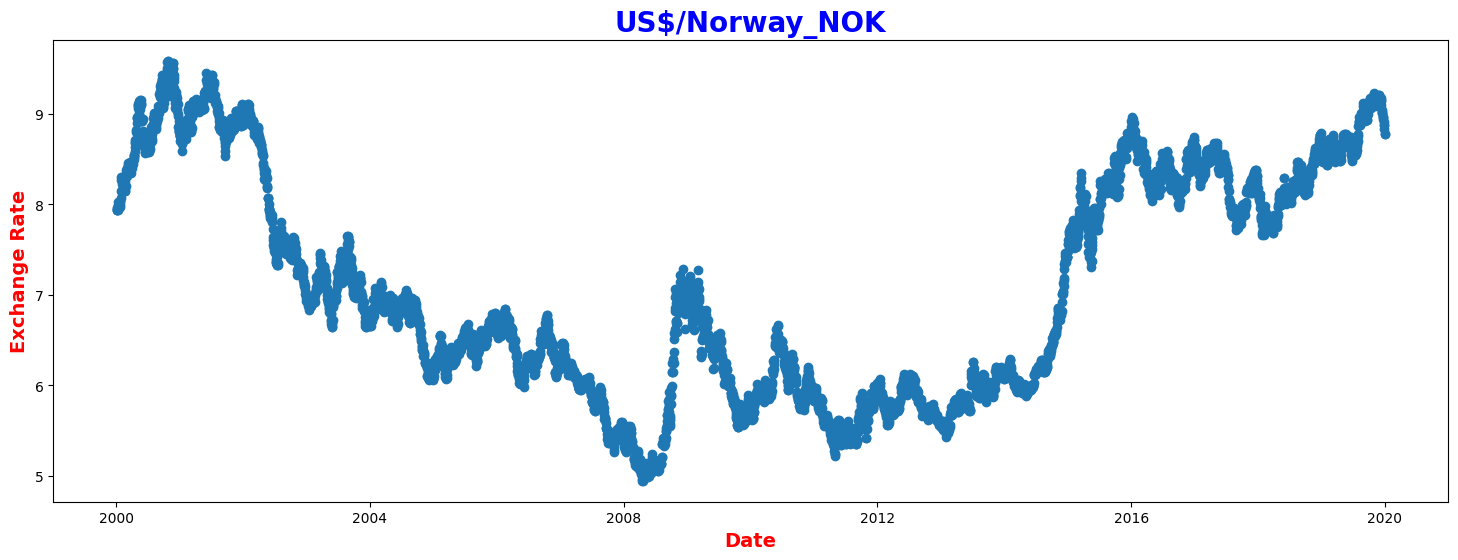

In [12]:
scatter_plot(nor_df, "US$")

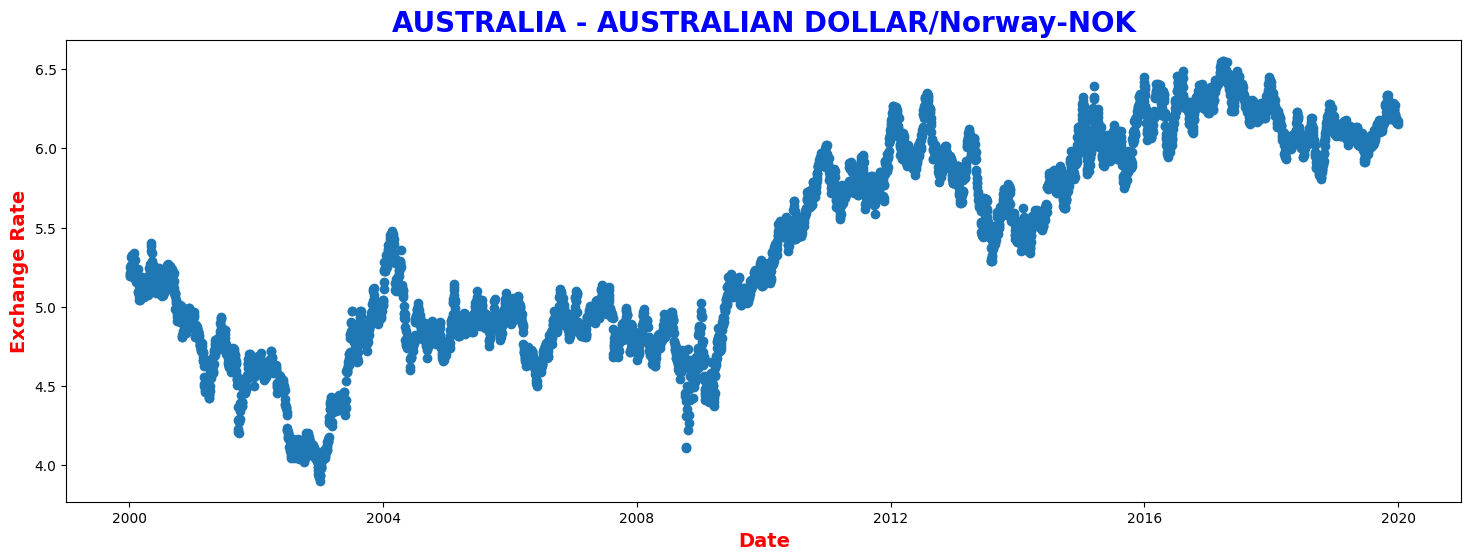

In [13]:
scatter_plot(nor_df, 'AUSTRALIA')

## predict US$/NOK using LSTM

In [46]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#Defining the LSTM model
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [94]:
us_nok_data = nor_df['US$/Norway_NOK']
data = np.array(us_nok_data).reshape(-1, 1)

In [ ]:
data

In [49]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [95]:
#Training and test sets
train = data[:4700]
test = data[4700:]

print(train.shape)
print(test.shape)

(4700, 1)
(517, 1)


In [96]:
def get_IO_data(data, input_window, predict_window):
  datax, datay = [],[]
  for i in range(len(data)-input_window-predict_window):
    datax.append(data[i:(i+input_window),0])
    datay.append(data[i+input_window:(i+input_window+predict_window),0])
  return np.array(datax) , np.array(datay)

In [97]:
input_window = 336
predict_window = 15

train_X, train_Y = get_IO_data(train, input_window=input_window, predict_window=predict_window)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-train-x', train_X)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-train-y', train_Y)
print(train_X.shape)
print(train_Y.shape)

(4349, 336)
(4349, 15)


In [98]:
test_X, test_Y = get_IO_data(test, input_window=input_window, predict_window=predict_window)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-test-x', test_X)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-test-y', test_Y)
print(test_X.shape)
print(test_Y.shape)

(166, 336)
(166, 15)


In [ ]:
print(test_X[:10])
print(test_Y[:10])

In [80]:
#Processing train and test sets for LSTM model
num_feature = 1

train_X = train_X.reshape(train_X.shape[0],train_X.shape[1], num_feature)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1], num_feature)
print(train_X.shape)
print(test_X.shape)

(4655, 30, 1)
(472, 30, 1)


In [81]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(input_window, num_feature)))
model.add(Dense(predict_window))

In [82]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 15)                1515      
                                                                 
Total params: 42,315
Trainable params: 42,315
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.compile(optimizer='adam', loss = 'mse')

In [84]:
#Training
model.fit(train_X,train_Y, epochs = 5, batch_size=1)

Epoch 1/5
4655/4655 [==============================] - 87s 18ms/step - loss: 0.0071
Epoch 2/5
4655/4655 [==============================] - 83s 18ms/step - loss: 0.0014
Epoch 3/5
4655/4655 [==============================] - 84s 18ms/step - loss: 0.0013
Epoch 4/5
4655/4655 [==============================] - 81s 17ms/step - loss: 0.0012
Epoch 5/5
4655/4655 [==============================] - 84s 18ms/step - loss: 0.0011


In [ ]:
pred_Y = model.predict(test_X)
pred_Y = scaler.inverse_transform(pred_Y)
print(pred_Y[:10])


In [ ]:
pred_Y.shape

In [86]:
#Processing test shape
test_Y = np.array(test_Y).reshape(-1,predict_window)
test_Y = scaler.inverse_transform(test_Y)
test_Y.shape

(472, 15)

In [ ]:
print(test_Y[:10])

In [ ]:
#Visualizing the results
plt.figure(figsize=(10,5))
plt.title('Foreign Exchange Rate of US vs Norway')
plt.plot(test_Y , label = 'Actual', color = 'g')
plt.plot(pred_Y , label = 'Predicted', color = 'r')
plt.legend()

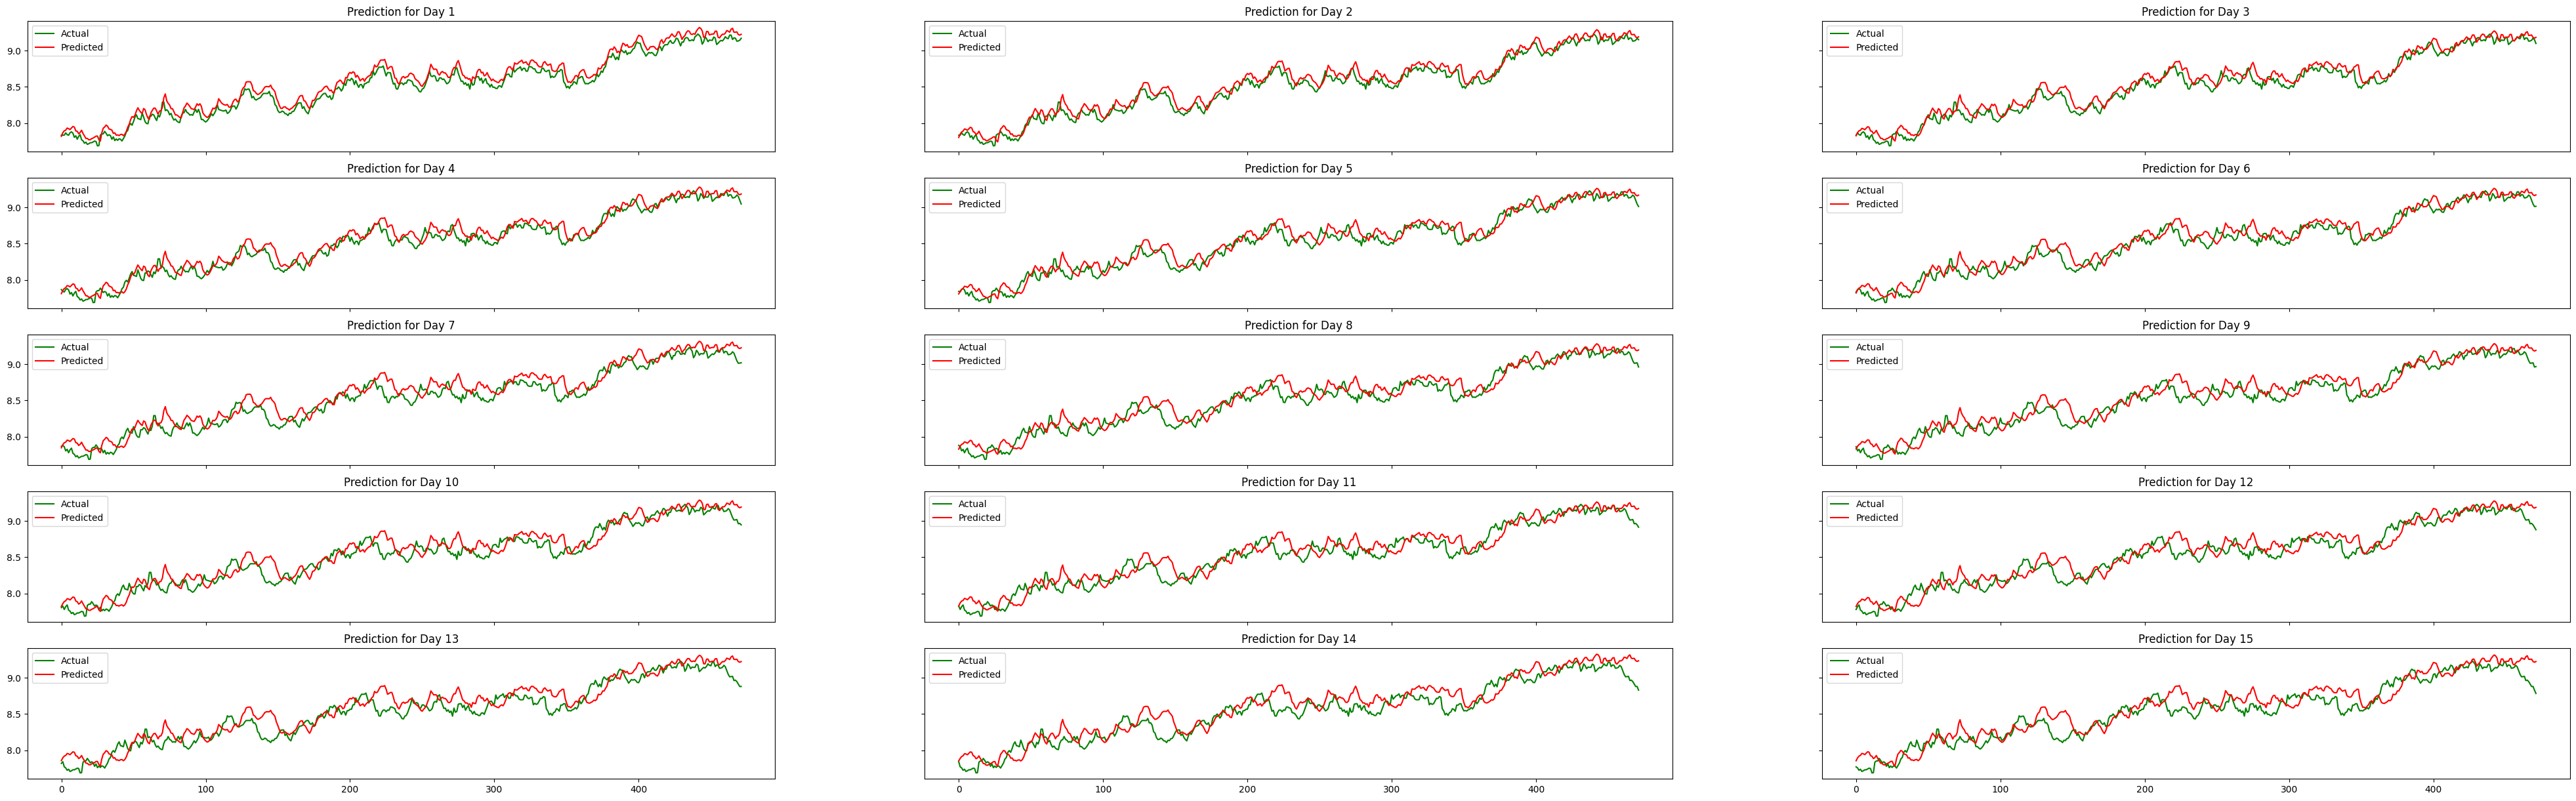

In [88]:
#Visualizing each day prediction results
# plt.figure(figsize=(30,25))
# plt.title('Foreign Exchange Rate of US vs Norway')

fig, axs = plt.subplots(5, 3, sharex='all', sharey='all', figsize=(50,15))

for i in range(predict_window):
  axs[i//3, i%3].plot(test_Y[:, i] , label = 'Actual', color = 'g')
  axs[i//3, i%3].plot(pred_Y[:, i] , label = 'Predicted', color = 'r')
  axs[i//3, i%3].title.set_text(f"Prediction for Day {i+1}")
  axs[i//3, i%3].legend()

In [89]:
from sklearn.metrics import mean_squared_error
print((f"Prediction MSE for ALL"))
print(mean_squared_error(test_Y, pred_Y))
for i in range(predict_window):
  print((f"Prediction MSE for Day {i+1}"))
  print(mean_squared_error(test_Y[:, i], pred_Y[:, i]))

Prediction MSE for ALL
0.015732594907560925
Prediction MSE for Day 1
0.008604509228325579
Prediction MSE for Day 2
0.007309368787230631
Prediction MSE for Day 3
0.009031982141756585
Prediction MSE for Day 4
0.01063828443247173
Prediction MSE for Day 5
0.01101701863454349
Prediction MSE for Day 6
0.012901903646742369
Prediction MSE for Day 7
0.018574102038604826
Prediction MSE for Day 8
0.015489250987467527
Prediction MSE for Day 9
0.017567254270160804
Prediction MSE for Day 10
0.01818062287317566
Prediction MSE for Day 11
0.017765467394899693
Prediction MSE for Day 12
0.018539653966377013
Prediction MSE for Day 13
0.022791497345068284
Prediction MSE for Day 14
0.024168355284104492
Prediction MSE for Day 15
0.023409652582485167


# Predict US$/Norway-NOK using DLinear

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class PredictionModel(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(PredictionModel, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.device = configs.device

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)

            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]


In [25]:
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
import random
import pandas as pd
import numpy as np
import os


class EXDataset(IterableDataset):
    def __init__(self, filepath, batch_size):
        self.filepath = filepath
        self.batch_size = batch_size

    def __iter__(self):
        return self

    def __next__(self):
        data = np.load(self.filepath)
        batches = np.array_split(data, len(data) // self.batch_size)
        for batch in batches:
            yield batch


In [91]:
class Config():

  def __init__(self, seq_len, pred_len, individual, enc_in, device, kernel_size=25):
    self.seq_len = seq_len
    self.pred_len = pred_len
    self.individual = individual
    self.enc_in = enc_in
    self.kernel_size = kernel_size
    self.device = device

  def get_seq_len(self):
    return self.seq_len
  def set_seq_len(self, value):
    self.seq_len = value

  def get_pred_len(self):
      return self.pred_len
  def set_pred_len(self, value):
    self.pred_len = value

  def get_individual(self):
    return self.individual
  def set_individual(self, value):
    self.individual = value

  def get_enc_in(self):
    return self.enc_in
  def set_enc_in(self, value):
    self.enc_in = value

  def get_device(self):
    return self.device
  def set_device(self, value):
    self.device = value

  def get_kernel_size(self):
    return self.kernel_size
  def set_kernel_size(self, value):
    self.kernel_size = value

In [74]:
import time
import numpy as np
import tensorflow as tf


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
configs = Config(seq_len=336, pred_len=15, individual=False, enc_in=1, device=device)
model = PredictionModel(configs).to(device)

epochs = 300
batch_size = 32
lr = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

filepath = './drive/MyDrive/Projects/exchange-rate/data/'
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
start_time = time.time()
train_loss = []

for epoch in range(epochs):
  train_x = EXDataset(filepath + 'nor-exr-train-x.npy', batch_size)
  train_y = EXDataset(filepath + 'nor-exr-train-y.npy', batch_size)
  x_batches = next(iter(train_x))
  y_batches = next(iter(train_y))
  for x, y in zip(x_batches, y_batches):
    x = torch.from_numpy(x.astype(np.float32)).to(device)
    y = torch.from_numpy(y.astype(np.float32)).to(device)
    x = x.reshape(x.shape[0],x.shape[1], model.channels) #(batch, output_len, channel)
    y_pred = model(x)
    y_pred = y_pred.reshape(-1,y_pred.shape[1]) #(batch * channel, output_len)
    assert y_pred.shape == y.shape, f"y_pred shape is not equal to y shape"
    # print(y_pred[:5,:])
    # print(y[:5,:])
    loss = criterion(y_pred, y)
    train_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"average train loss: {np.average(train_loss)}")
  train_loss = []

best_model_path = filepath + 'checkpoint.pth'
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, best_model_path)


#Predict
model.load_state_dict(torch.load(best_model_path)['model_state_dict'])
test_x = EXDataset(filepath+'nor-exr-test-x.npy', batch_size)
x_batches = next(iter(test_x))
y = np.load(filepath+'nor-exr-test-y.npy')
y = torch.from_numpy(y.astype(np.float32))

outputs = []
with torch.no_grad():
  for x in x_batches:
    x = torch.from_numpy(x.astype(np.float32)).to(device)
    x = x.reshape(x.shape[0],x.shape[1], model.channels) #(batch, output_len, channel)
    output = model(x).detach().cpu().numpy()
    output = output.reshape(-1,output.shape[1]) #(batch * channel, output_len)
    print(f"output shape:{output.shape}")
    outputs.append(output)

y_pred = tf.concat(outputs, axis=0)
print(y.shape)



average train loss: 0.07070724423543584
average train loss: 0.016896096742884427
average train loss: 0.014423203381226846
average train loss: 0.012219636512627067
average train loss: 0.010442243080318872
average train loss: 0.009034896144401972
average train loss: 0.007924438334022718
average train loss: 0.0070460582352502065
average train loss: 0.006346914971126588
average train loss: 0.005785352676348002
average train loss: 0.0053291201507413965
average train loss: 0.004953535336621658
average train loss: 0.004639872562364433
average train loss: 0.0043740320159553515
average train loss: 0.004145469130836082
average train loss: 0.003946342739315393
average train loss: 0.0037708321930107628
average train loss: 0.003614606983912246
average train loss: 0.003474413205360718
average train loss: 0.0033477627462060707
average train loss: 0.003232710549168082
average train loss: 0.003127694942803053
average train loss: 0.003031430420944364
average train loss: 0.002942838975340473
average trai

In [ ]:
for para in model.parameters():
  print(para)

In [75]:
print(y_pred[:2,])

tf.Tensor(
[[0.7577179  0.758013   0.7499214  0.7492969  0.75470734 0.76038665
  0.76631063 0.768175   0.7686689  0.76204205 0.7541371  0.7468759
  0.74176294 0.7373506  0.7378778 ]
 [0.7695776  0.77320904 0.76007926 0.762193   0.7686792  0.77358377
  0.77469957 0.7775167  0.7727048  0.7702446  0.7643933  0.75734824
  0.75163466 0.7491486  0.7430117 ]], shape=(2, 15), dtype=float32)


In [64]:
print(y[:2,])

tensor([[0.7763, 0.7873, 0.8006, 0.8029, 0.8035, 0.7963, 0.7950, 0.8220, 0.8097,
         0.8147, 0.8195, 0.8212, 0.8254, 0.8144, 0.8205],
        [0.7873, 0.8006, 0.8029, 0.8035, 0.7963, 0.7950, 0.8220, 0.8097, 0.8147,
         0.8195, 0.8212, 0.8254, 0.8144, 0.8205, 0.8210]])


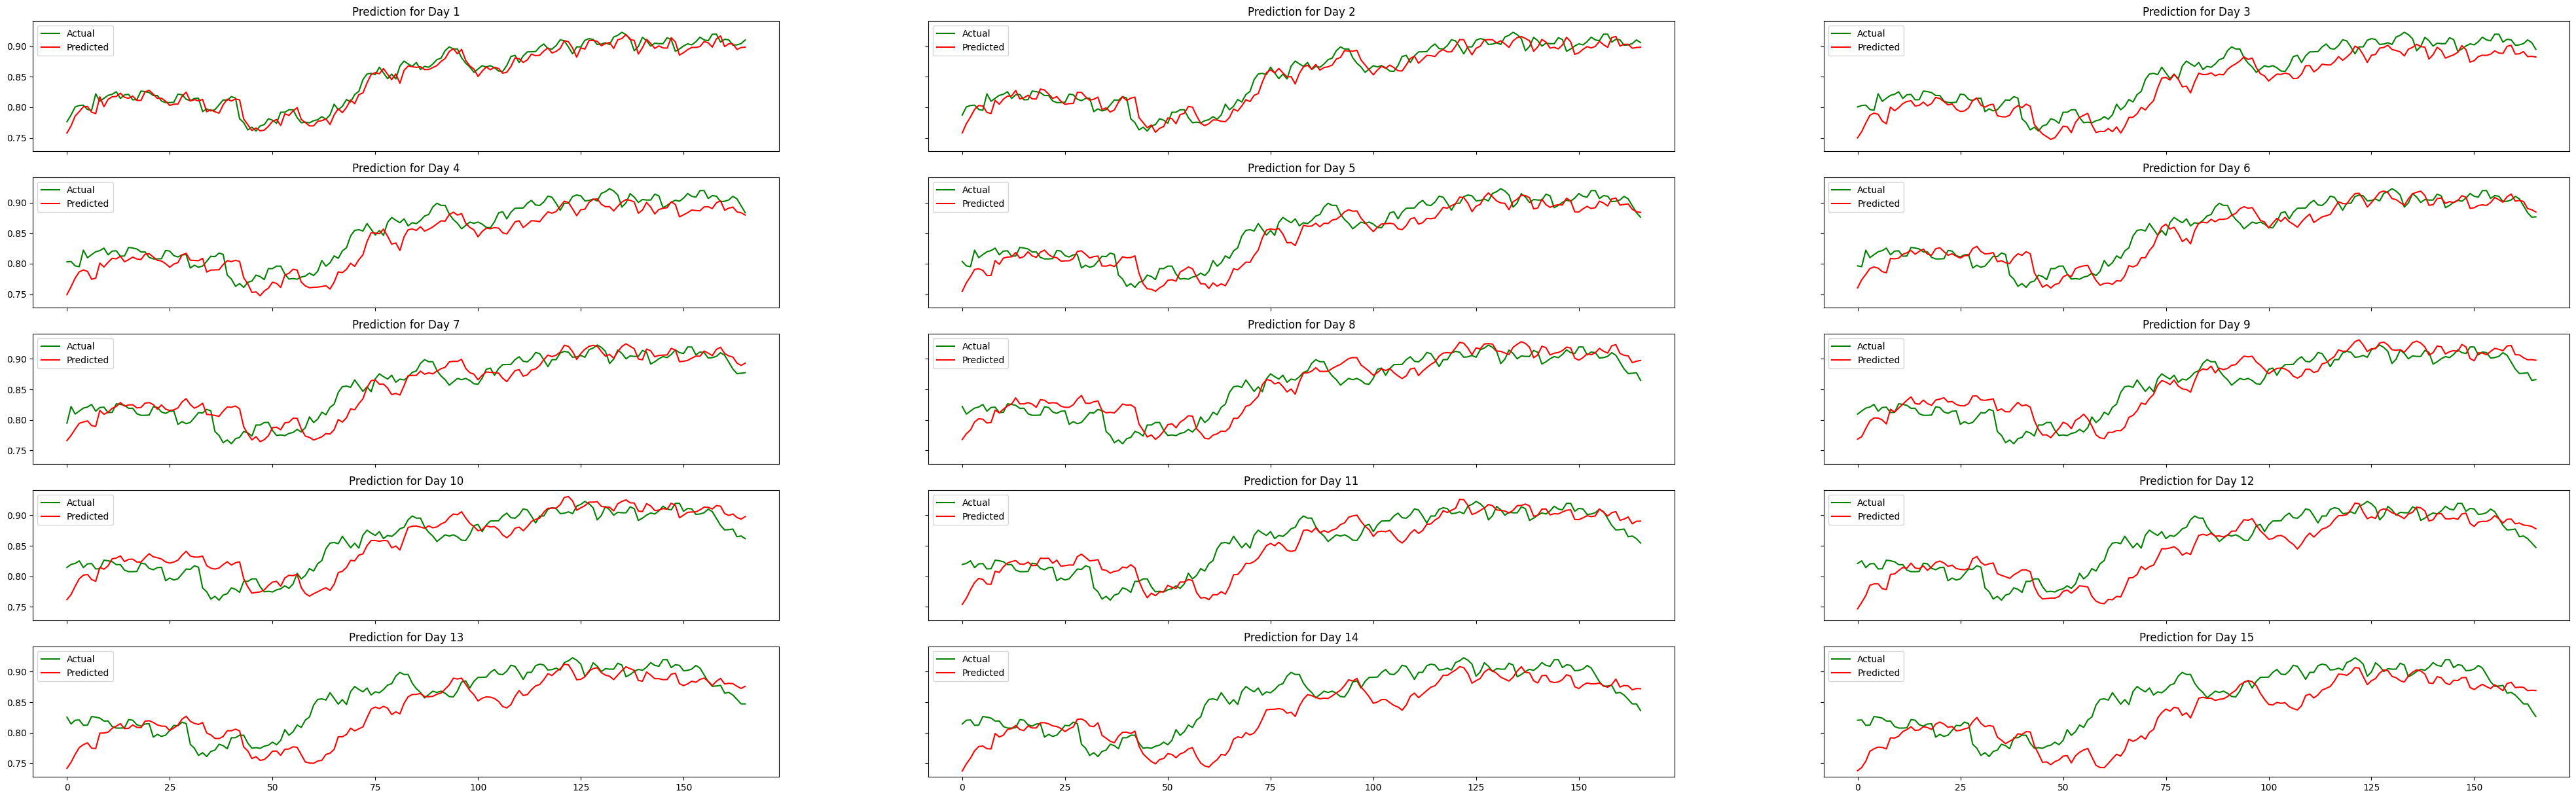

In [76]:
fig, axs = plt.subplots(5, 3, sharex='all', sharey='all', figsize=(50,15))

for i in range(configs.get_pred_len()):
  axs[i//3, i%3].plot(y[:, i] , label = 'Actual', color = 'g')
  axs[i//3, i%3].plot(y_pred[:, i] , label = 'Predicted', color = 'r')
  axs[i//3, i%3].title.set_text(f"Prediction for Day {i+1}")
  axs[i//3, i%3].legend()

In [77]:
from sklearn.metrics import mean_squared_error
print((f"Prediction MSE for ALL"))
print(mean_squared_error(y, y_pred))
for i in range(predict_window):
  print((f"Prediction MSE for Day {i+1}"))
  print(mean_squared_error(y[:, i], y_pred[:, i]))

Prediction MSE for ALL
0.0007048789
Prediction MSE for Day 1
0.00010074189
Prediction MSE for Day 2
0.00017901586
Prediction MSE for Day 3
0.000520133
Prediction MSE for Day 4
0.00054611184
Prediction MSE for Day 5
0.000475532
Prediction MSE for Day 6
0.00044344613
Prediction MSE for Day 7
0.00046668435
Prediction MSE for Day 8
0.0005348202
Prediction MSE for Day 9
0.00060450134
Prediction MSE for Day 10
0.0006629174
Prediction MSE for Day 11
0.0007575055
Prediction MSE for Day 12
0.00096276385
Prediction MSE for Day 13
0.0012296468
Prediction MSE for Day 14
0.0014501788
Prediction MSE for Day 15
0.0016391844


# Predicting US$/Norway-NOK using NLinear

# Predict US$/Norway-NOK with Autoformer

In [ ]:
!pip install huggingface_hub
!pip install transformers

In [ ]:
from transformers import AutoformerConfig, AutoformerModel

# Initializing a default Autoformer configuration
prediction_length = 15
context_length = 15
configuration = AutoformerConfig(prediction_length=prediction_length, context_length=context_length)

# Randomly initializing a model (with random weights) from the configuration
model = AutoformerModel(configuration)

# Accessing the model configuration
configuration = model.config

In [ ]:
print(configuration)

In [ ]:
from huggingface_hub import hf_hub_download
import torch
from transformers import AutoformerForPrediction



In [ ]:
file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

In [ ]:
batch["past_values"].shape

In [ ]:


model = AutoformerForPrediction.from_pretrained("huggingface/elisim/autoformer-exchange-rate-50-epochs_")

# during training, one provides both past and future values
# as well as possible additional features
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
)

loss = outputs.loss
loss.backward()

# during inference, one only provides past values
# as well as possible additional features
# the model autoregressively generates future values
outputs = model.generate(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_time_features=batch["future_time_features"],
)

mean_prediction = outputs.sequences.mean(dim=1)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Model(nn.Module):
    """
    Normalization-Linear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Use this line if you want to visualize the weights
        # self.Linear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        self.channels = configs.enc_in
        self.individual = configs.individual
        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x # [Batch, Output length, Channel]